## Example: Pharmacokinetic model

In this notebook we provide an example which finds the optimal design for a compartmental pharmacokinetic model using stochastic gradient descent (SGD).

#### Data Model

In this example, observations of the drug inside the body, $y_i$, at time $\tau_i$ (hours) are distributed normally

$$
y_i \sim N(x(\theta, \tau_i), \sigma_1^2 + \sigma_2^2 x(\theta,\tau_i)^2),
$$

with

$$
x(\theta, \tau_i) = \frac{D\theta_2}{\theta_3(\theta_2 - \theta_1)}\Big(e^{-\theta_1 \tau_i} - e^{-\theta_2 \tau_i}\Big),
$$

where $D=400$.

The parameters of interest, $\theta$, follow a log-normal distribution, $\log \theta_j \sim N(m_j, 0.05)$, independently for $j=1,2,3$ and $m = (\log 0.1,\log 1,\log 20)$.

Here we wish to find the optimal $15$ observation design where times are restricted to $[0,24]$. Furthermore we treat $\sigma_1$ and $\sigma_2$ as known.

#### Utility Function

In this illustration we use the fisher information gain (FIG) as the chosen utility function. This quantifies how much is leaned about the parameter of interest at a given design time.

For the pharmacokinetic model the FIG is given by

$$
\text{tr} \mathcal{I}(\theta; \tau)
= \sum_{i=1}^d v_i(\theta, \tau)^T \Sigma(\tau)^{-1} v_i(\theta, \tau)
$$

where

$$
\begin{align*}
\nu_{1j} &= \frac{1}{\theta_2 - \theta_1}x(\theta, \tau_j) - \frac{D\theta_2}{\theta_3(\theta_2 - \theta_1)}\tau_je^{-\theta_1\tau_j}, \\
\nu_{2j} &= \frac{\theta_1}{\theta_2(\theta_1-\theta_2)}x(\theta, \tau_j) + \frac{D\theta_2}{\theta_3(\theta_2 - \theta_1)}\tau_je^{-\theta_2\tau_j}, \\
\nu_{3j} &= - \frac{1}{\theta_3} x(\theta, \tau_j).
\end{align*}
$$

and utility

$$
U_{FIG}(\tau) = \mathbb{E}_\theta[ \text{tr} I_\theta(\theta) ].
$$

To estimate the expectation over $\theta$, a Monte Carlo estimate is used.

#### Using SGD to target the optimal design

Here we use the Tensorflow module to implement a SGD algorithm on the loss function (negated utility function) searching over the design space. Any SGD method can be applied; here we use the adaptive moment estimation (Adam).

## Implementation using Tensorflow

First import the dependencies.

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

Define the constants. Here we randomly generate the initial state uniformly over the search space $[0,24]^{15}$.

In [3]:
nobs = 15 #set the number of observation required for the design
sig2_add = 0.1 #set value of sigma1^2
sig2_mult = 0.0 #set value of sigma2^2

initial_design = np.sort(np.random.uniform(low=0., high=24., size=[nobs]))

Define the prior distribution for the model parameters $\theta$.

In [4]:
pri_dist_ln = tfp.distributions.MultivariateNormalDiag(
                loc = np.log([0.1, 1.0, 20.0], dtype = np.float32),
                scale_diag = np.sqrt([0.05, 0.05, 0.05], dtype = np.float32)
                )

Next we define the model and FIG using Tensorflow. Note that we are using a descent algorithm rather than an ascent algorithm hence by default this will minimise the objective function. Thus the loss function, defined the negated utility function, is used as the objective function here.

In [5]:
# use the sampled initial_design as the value to initialise the design at
design = tf.Variable(tf.constant(initial_design, dtype=tf.float32))
# sample theta
theta = tf.exp(pri_dist_ln.sample([]))
# calculate the mean 
x = 400. * theta[1] * (tf.exp(-theta[0]*design) - tf.exp(-theta[1]*design)) / (theta[2]*(theta[1]-theta[0]))
# calculate the gradients needed to calculate the FIG
grad0 = x/(theta[1]-theta[0]) - design*400.*theta[1]/(theta[2]*(theta[1]-theta[0]))*tf.exp(-theta[0]*design)
grad1 = x/theta[1] - x/(theta[1]-theta[0]) + design*400.*theta[1]*tf.exp(-theta[1]*design)/(theta[2]*(theta[1]-theta[0]))
grad2 = -x/theta[2]
# define sigma
Sigma = sig2_add + sig2_mult*tf.pow(x,2.)
# compute the diagonal elements of the fisher information matrix
fig0 = tf.reduce_sum(tf.pow(grad0,2.)*tf.pow(Sigma,-1.) + 2.*tf.pow(sig2_mult*grad0*x,2.)*tf.pow(Sigma,-2.))
fig1 = tf.reduce_sum(tf.pow(grad1,2.)*tf.pow(Sigma,-1.) + 2.*tf.pow(sig2_mult*grad1*x,2.)*tf.pow(Sigma,-2.))
fig2 = tf.reduce_sum(tf.pow(grad2,2.)*tf.pow(Sigma,-1.) + 2.*tf.pow(sig2_mult*grad2*x,2.)*tf.pow(Sigma,-2.))
# put together into one array
fig_vec = tf.stack([fig0, fig1, fig2])
# define the weighting used for the components of the FIG
weights = tf.constant([5.0e05, 3.0e3, 70])
# compute FIG
fig = tf.reduce_sum(fig_vec / weights)
# compute the loss function (-FIG), based on only 1 estimate being used in MC estimate
loss = -fig

Next, we define the optimiser and initialise the global variables.

In [6]:
optimiser = tf.train.AdamOptimizer()
train = optimiser.minimize(loss)
init = tf.global_variables_initializer()

We can now run the stochastic optimisation for a set number of iterations. Here we will use $5 \times 10^4$ iterations.

In [7]:
# split the iterations into blocks so that it is easy to include a convergence criterion
# also reduces memory required if lots of iterations are required
nloops = 500
its_per_loop = 100

iterations = np.zeros(nloops)
designs = np.zeros([nloops, nobs])
losses = np.zeros(nloops)

with tf.Session() as sess:
    sess.run(init)
    for i in range(nloops):
        mean_loss = 0.
        for j in range(its_per_loop):
            next_loss, next_design, _ = sess.run([loss, design, train])
            mean_loss += next_loss
        mean_loss /= its_per_loop
        print("Current loop: {:3d}  Current utility: {:.3f}".format(i, -1.* mean_loss), end="\r")
        iterations[i] = i*its_per_loop
        designs[i, :] = next_design
        losses[i] = mean_loss
        mean_loss = 0.

Now we can make plots of the output.

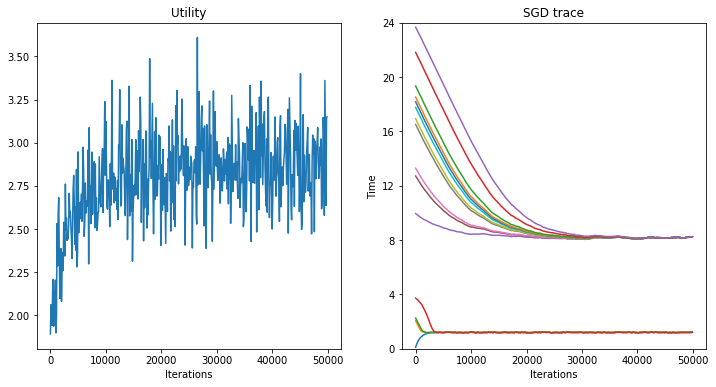

In [8]:
fig = plt.figure()
fig.set_size_inches(12,6)

# plot the trace of the utility
plt.subplot(1,2,1)
plt.plot(iterations,-losses) # utility = -1 * loss
plt.title('Utility')
plt.xlabel('Iterations')

# plot the trace of the design
plt.subplot(1,2,2)
for i in range(nobs):
    plt.plot(iterations, designs[:,i])
plt.ylim(0,24)
plt.yticks(np.arange(7)*4, np.array(np.arange(7)*4, np.str))
plt.title('SGD trace')
plt.xlabel('Iterations')
plt.ylabel('Time')

plt.show()